# NYC MTA Turnstile Data Analysis
___

## 1. Data Description & Purpose
---

We will be analysing NYC MTA Turnstile dataset - which tracks passenger entries & exist from subway stations throughtout NYC.  The data is summarized at a 4 hour interval.  

[Source](http://web.mta.info/developers/turnstile.html)

[Field Descriptions](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)

The purpose of this analysis is to identify the busyness of the NYC subway system during the August to October months.  We will do this by identifying total ridership per station per day over the months of August to October (2016) timeframe.

In a prior notebook (see: nyc_mta_cleaning), we cleaned the mta dataset and placed the data into a csv.  We will import this csv and begin to explore several variables
* Ridership per station
*

## 2. Import Data

 We've previously stored the data in a csv named 'nyc_mta_data_cleaned.csv'.  Let's bring this into a dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
nyc_mta = pd.read_csv('./data/nyc_mta_data_cleaned.csv', parse_dates=['date'])
nyc_mta.set_index(['date', 'station', 'line', 'division'], inplace=True)

In [3]:
# take a quick look at the data
nyc_mta.head()

,,,,daily_ridership
date,station,line,division,
2016-07-31,59 ST,NQR456,RIT,7965
2016-08-01,59 ST,NQR456,RIT,15594
2016-08-02,59 ST,NQR456,RIT,17262
2016-08-03,59 ST,NQR456,RIT,17538
2016-08-04,59 ST,NQR456,RIT,17523


In [4]:
nyc_mta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42880 entries, (2016-07-31 00:00:00, 59 ST, NQR456, RIT) to (2016-10-28 00:00:00, RIT-ROOSEVELT, R, RIT)
Data columns (total 1 columns):
daily_ridership    42880 non-null int64
dtypes: int64(1)
memory usage: 549.1+ KB


In [5]:
nyc_mta.describe()

,daily_ridership
count,42880.000000
mean,10247.759468
std,12470.722671
min,0.000000
25%,3564.000000
50%,6664.000000
75%,12428.000000
max,184808.000000


## 2. Exploring Ridership Per Station

What does the ridership perstation per day look like?

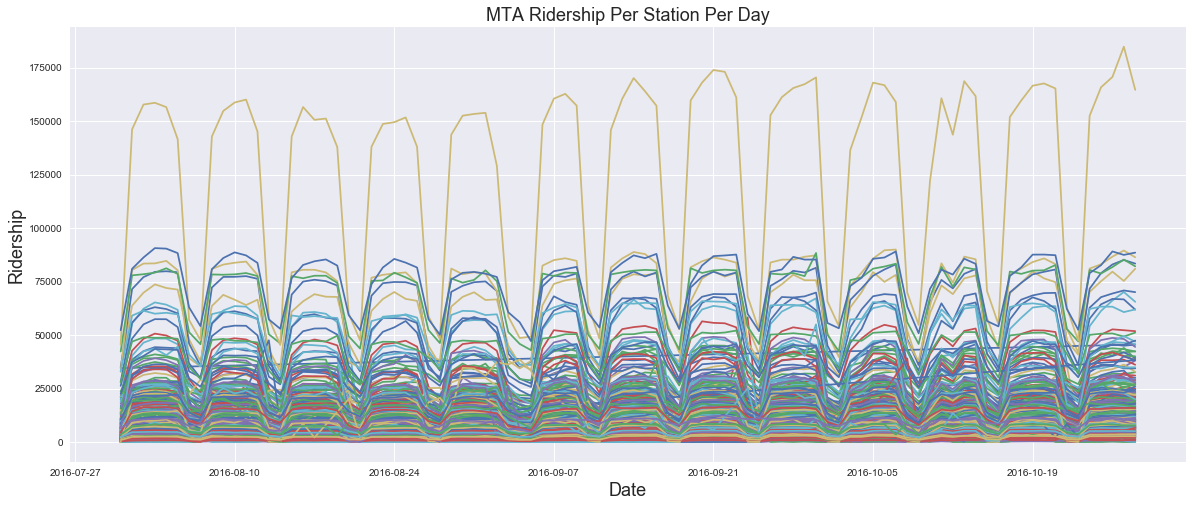

In [6]:
# set figure size
fig, ax = plt.subplots(figsize=(20,8))

# let's reset the index for plotting purposes
rps = nyc_mta.reset_index()
rps.set_index(['station', 'line', 'division'], inplace=True)

# loop through stations and plot ridership
for idx, df in rps.groupby(level=[0,1,2]):
    dates = df.date.values
    ridership = df.daily_ridership.values
    plt.plot(dates, ridership)

# set labels
plt.title('MTA Ridership Per Station Per Day', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Ridership', fontsize=18)
fig.savefig('./figures/nyc_mta_ridership_per_station_per_day')
plt.show()


We can see that ridership as a whole has ups and downs - my expectation is that 
* The peaks we see are weekdays, and the valleys are weekends.  
* There are several stations that have majority of the ridership.  My assumption is that these are the large stations like grand central.
* Ridership begins to increas leading into September & October.  This is likely do to weather becoming cooler and less pleasant. 
* There is one dip in October during a weekday.  This is likely a reflection of the Columbus Day holiday. 

Let's continue to explore total ridership

## 3. Exploring Total Ridership

We've seen ridership per station.  What does the total riderhsip look like? 

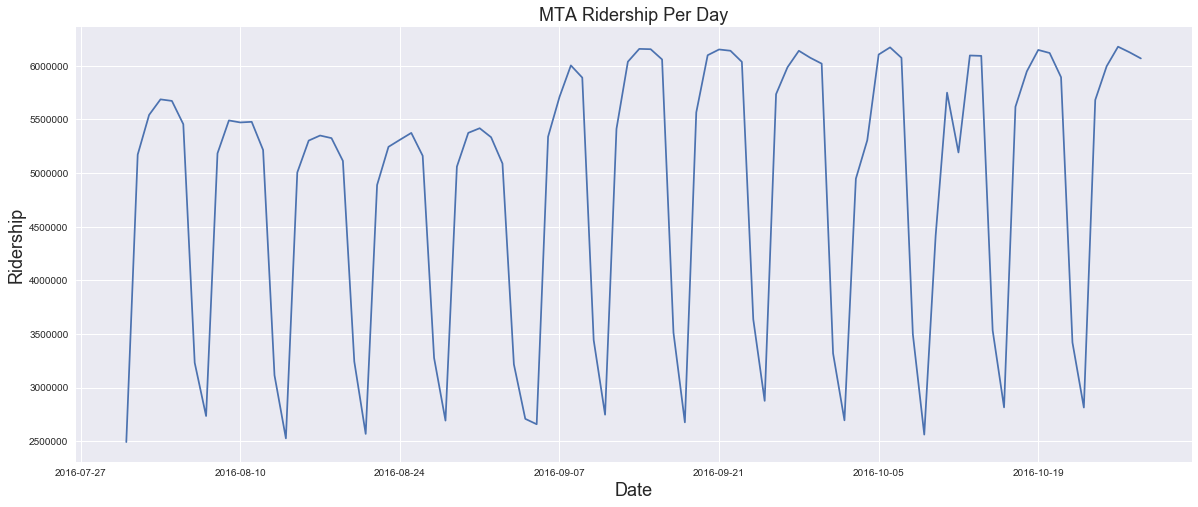

In [7]:
from collections import Counter

daily_total = Counter()

# let's reset the index for plotting purposes
tr = nyc_mta.reset_index()
tr.set_index(['date'], inplace=True)

# loop through stations and plot ridership
for idx, df in tr.groupby(level=[0]):
    daily_total[idx]+= df.daily_ridership.sum()

# get our values to plot
dates = list(daily_total.keys())
ridership = list(daily_total.values())
    
# set figure size
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(dates, ridership)

# set labels
plt.title('MTA Ridership Per Day', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Ridership', fontsize=18)

fig.savefig('./figures/nyc_mta_ridership_per_day')
plt.show()



Examining the total ridership per day, the peaks and valleys become very apparent.  we know:

* Ridership increases beginning september
* Ridership is significantly higher on weekdays than weekends
* Ridership is affected by holidays (Columbus Day in October)

## 3. Exploring ridership as it relates to the day of the week

We assume, based on the above graphs, that ridership is considerably higher on weekdays when compared to weekends.  What is the average ridership for each day of the week? 

In [8]:
from collections import defaultdict

def group_by_day_of_week(data):
    """
        Accepts a dictionary of ridership totals per day
        
        Summarizes the ridership per day of the week and determines
        the average ridership per day.  
    """
       
    day_of_week_total = defaultdict(list)
    day_of_week_avg = {}

    for day, count in daily_total.items():   
        day_of_week_total[day.weekday()].append(count)
    
    for i in range(7):
        day_of_week_avg[i] = sum(day_of_week_total[i]) / len(day_of_week_total[i])

    return day_of_week_avg



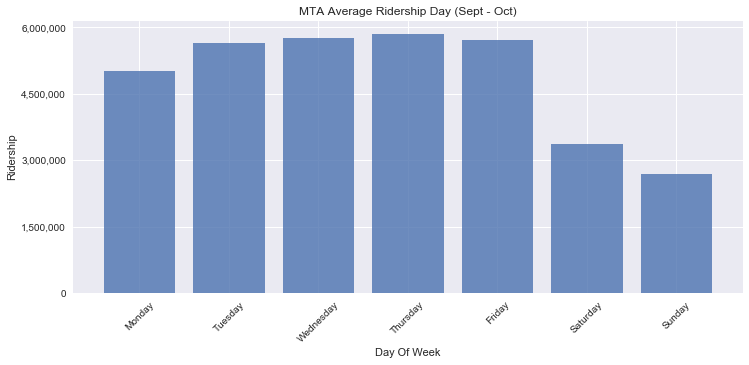

{0: 5027074.384615385, 1: 5647966.923076923, 2: 5771389.461538462, 3: 5852310.846153846, 4: 5705921.384615385, 5: 3370928.0, 6: 2685551.6153846155}


In [9]:
# find the daily averages
day_of_week_avg = group_by_day_of_week(daily_total)   

# get our data
x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = list(day_of_week_avg.keys())
counts = list(day_of_week_avg.values())

# Plot the graph
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(days, counts, alpha=0.8)

# set x ticks
#ax.set_xticklabels(x_labels)
plt.xticks(np.arange(min(days), max(days)+1, 1), x_labels, rotation=45)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add labels
plt.title('MTA Average Ridership Day (Sept - Oct)')
plt.ylabel('Ridership')
plt.xlabel('Day Of Week')

fig.savefig('./figures/nyc_mta_avg_ridership_per_day_of_week')
plt.show()

print(day_of_week_avg)

Based on the above, we can see that MTA ridership is significantly varies by day.

| Day of Week | Avg Ridership |
| ----------- | :-------------: |
| Monday      | 5,027,074.38 |
| Tuesday | 5,647,966.92 |
| Wednesday | 5,771,389.46 |
| Thursday | 5,852,310.84 |
| Friday | 5,705,921.38 |
| Saturday | 3,370,928.0 | 
| Sunday | 2,685,551.61 |

Specifically speaking towards the weekdays, Thursday's have the highest ridership, where as mondays have the lowest.

## 4. Exploring Top Stations

What are the top 15 stations in MTA during our Aug to Sept analysis?

In [10]:
def find_station_total(data):
    """
        returns a dictionary of the total ridership per station
    """

    trps = data.reset_index()
    trps.set_index(['station', 'line', 'division'], inplace=True)

    station_totals = Counter()

    # loop through stations and plot ridership
    for idx, df in trps.groupby(level=[0,1,2]):
        station = idx 
        station_totals[station]+=df.daily_ridership.sum()
    
    return station_totals

In [11]:
import operator

# find the station totals
st = find_station_total(nyc_mta)

# sort the totals in reverse order
sorted_st = sorted(st.items(), key=operator.itemgetter(1), reverse=True)

# print out the top 15
for x in range(15):
    print(sorted_st[x])

(('GRD CNTRL-42 ST', '4567S', 'RIT'), 11446228)
(('34 ST-HERALD SQ', 'BDFMNQR', 'RIT'), 9202869)
(('TIMES SQ-42 ST', '1237ACENQRS', 'RIT'), 6761915)
(('42 ST-PORT AUTH', 'ACENQRS1237', 'RIT'), 6293570)
(('34 ST-PENN STA', 'ACE', 'RIT'), 6260369)
(('14 ST-UNION SQ', 'LNQR456', 'RIT'), 5712669)
(('86 ST', '456', 'RIT'), 4930670)
(('FLUSHING-MAIN', '7', 'RIT'), 4915498)
(('59 ST COLUMBUS', 'ABCD1', 'RIT'), 4553229)
(('47-50 STS ROCK', 'BDFM', 'RIT'), 4373001)
(('JKSN HT-ROOSVLT', 'EFMR7', 'RIT'), 4010089)
(('FULTON ST', '2345ACJZ', 'RIT'), 3869361)
(('59 ST', '456NQR', 'RIT'), 3815893)
(('W 4 ST-WASH SQ', 'ABCDEFM', 'RIT'), 3436941)
(('42 ST-BRYANT PK', 'BDFM7', 'RIT'), 3265150)


In [12]:
print('Number of stations: {}'.format(len(sorted_st)))

Number of stations: 473


We can see that Grand Central station is the top of the list.  Let's graph the results to see the top 30 stations

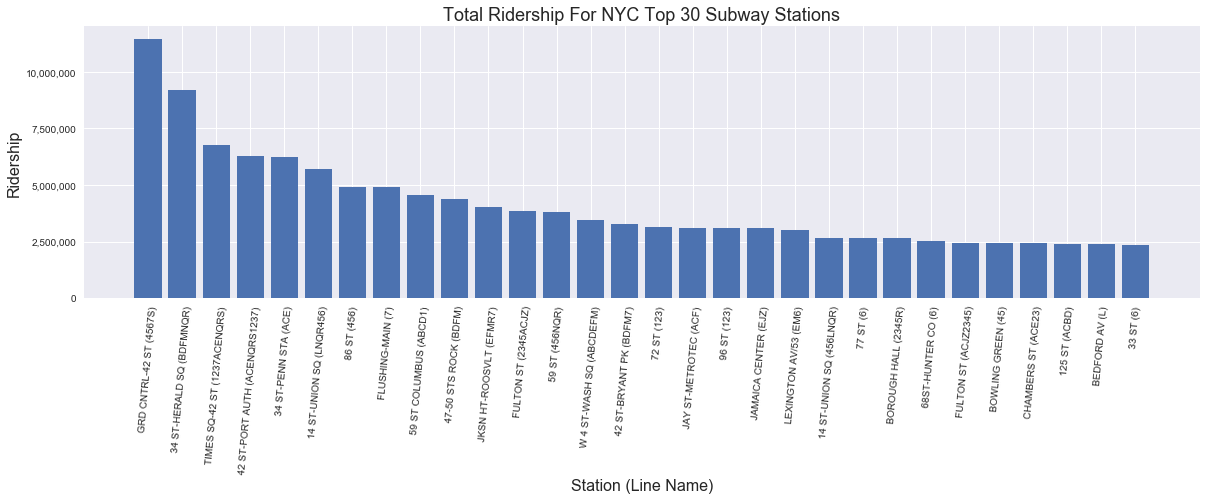

In [13]:
#import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker

station_names = ['{} ({})'.format(station, line) for (station, line, div), count in sorted_st]
station_names = station_names[:30]
ridership = [count for (station, line, div), count in sorted_st]
ridership = ridership[:30]

xaxis = np.arange(len(station_names))

# Plot the graph
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(xaxis, ridership)

# set x ticks
plt.xticks(np.arange(min(xaxis), max(xaxis)+1, 1), station_names, rotation=85)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set labels
plt.title('Total Ridership For NYC Top 30 Subway Stations', fontsize=18)
plt.ylabel('Ridership', fontsize=16)
plt.xlabel('Station (Line Name)', fontsize=16)
fig.savefig('./figures/nyc_mta_top_30_stations')

plt.show()

## 5. Conclusions

Historically:
* Weekdays are more likely to be busier than weekends (5.6 mil to 3.0 mil riders on avg)
* Ridership in September & October is greater than August.
* There are stations which have significantly larger traffic, which could be targeted over less busy areas (eg. Grand central station)